## Import các thư viện cần thiết

In [42]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

## Chuẩn bị dữ liệu

In [4]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('./Data/air_quality_cleaned.csv')

# Xem mẫu dữ liệu
data.head()

,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2021-01-01 00:00:00,3,700.95,0.44,35.99,17.35,32.90,20.33,26.64,8.99
1,2021-01-01 01:00:00,3,847.82,2.46,38.04,18.06,36.24,23.32,30.54,9.37
2,2021-01-01 02:00:00,3,894.55,5.25,38.39,23.25,41.01,24.16,31.93,9.25
3,2021-01-01 03:00:00,3,827.79,6.20,36.33,33.98,43.39,23.20,30.91,8.61
4,2021-01-01 04:00:00,2,660.90,3.69,29.13,54.36,35.76,19.50,25.60,6.21


In [5]:
# Kiểm tra thông tin cơ bản về dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25176 entries, 0 to 25175
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dt      25176 non-null  object 
 1   aqi     25176 non-null  int64  
 2   co      25176 non-null  float64
 3   no      25176 non-null  float64
 4   no2     25176 non-null  float64
 5   o3      25176 non-null  float64
 6   so2     25176 non-null  float64
 7   pm2_5   25176 non-null  float64
 8   pm10    25176 non-null  float64
 9   nh3     25176 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.9+ MB


## Huấn luyện mô hình

**Lựa chọn thuộc tính:** chúng em sẽ tiến hành phân loại chất lượng không khí theo chỉ số `aqi` dựa trên các chỉ số `no, co, so2, no2, o3, pm2_5, pm10, nh3`

In [6]:
# Chia dữ liệu thành features (X) và target variable (y)
X = data[['no', 'co', 'so2', 'no2', 'o3', 'pm2_5', 'pm10', 'nh3']]  # Chọn các chỉ số khí quyển làm features
y = data['aqi']  # Chọn cột AQI làm target variable

**Feature Scaling:**

- Khi khoảng giá trị giữa 2 thuộc tính quá cách xa nhau thì việc mô hình hóa cũng như trực quan mối quan hệ có thể gặp khó khăn, do đó phải thực hiện kĩ thuật 'Feature Scaling' hay việt hóa là 'Co giãn thuộc tính'.
- Có 3 phương pháp feature scaling chính là:
    - Standardisation (Chính quy hóa): Làm cho tập dữ liệu có trung bình là 0 và độ lệch chuẩn là 1 và được áp dụng cho hầu hết các trường hợp cần feature scaling.
    - Normalisation (Tiêu chuẩn hóa): Làm cho các giá trị trong tập dữ liệu thuộc đoạn [0, 1] và được áp dụng nếu tập dữ liệu tuân theo phân phối chuẩn.
    - MinMax Scaler: Đưa các giá trị về khoảng giữa 2 giá trị min và max trong miền giá trị của thuộc tính, có thể là đoạn [-1, 0], [0, 1], [-1, 1],...
- Trong bài này nhóm chọn phương pháp Standardisation để scaling khoảng giá trị của thuộc tính về khoảng gần hơn với giá trị của tập y là `aqi`.

In [7]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Phân tách bộ dữ liệu thành 3 tập training set, validation set và test set:**

- Mục đích:
    - Huấn luyện và đánh giá độc lập: Tập huấn luyện được sử dụng để huấn luyện mô hình. Tập kiểm tra được sử dụng để đánh giá hiệu suất tổng quát của mô hình. Dữ liệu này không được sử dụng trong quá trình huấn luyện để đảm bảo mô hình có khả năng tổng quát hóa với dữ liệu mới, đảm bảo tính khách quan.
    - Kiểm tra: Tập validation được sử dụng để tìm ra mô hình tốt nhất với những siêu tham số khác nhau.
    - Tránh overfitting: Nếu không chia dữ liệu mà sử dụng toàn bộ dữ liệu để huấn luyện, mô hình có thể học "quá khớp" (overfit) dữ liệu huấn luyện mà không tổng quát hóa được cho dữ liệu mới. Việc có tập kiểm tra giúp đánh giá xem mô hình có đang học từ dữ liệu một cách tổng quát hay chỉ học "nhớ" dữ liệu huấn luyện không.
    - Đánh giá và cải thiện mô hình: Thông qua việc đánh giá trên tập kiểm tra, chúng ta có thể đánh giá hiệu suất của mô hình và cải thiện nó thông qua việc điều chỉnh các tham số hoặc phương pháp huấn luyện.
- Kích thước mỗi tập như sau:
    - Size of Training set = 80% * (Size of Dataset)
    - Size of Test set = 20% * (Size of Dataset).

In [8]:
# Chia dữ liệu thành tập train và tập test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tiếp tục chia tập train thành tập train và tập validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

### 1. Mô hình Decision Tree

- Mô hình Decision Tree (cây quyết định) là một thuật toán học máy có cấu trúc dạng cây, chia dữ liệu dựa trên các quy tắc quyết định đơn giản. Mỗi nút lá của cây đại diện cho một nhãn hoặc một giá trị dự đoán, trong khi các nút gốc và nội bộ biểu diễn các quy tắc quyết định để chia tách dữ liệu.

- Cách hoạt động chính của Decision Tree:

    - Chọn thuộc tính quan trọng: Các thuộc tính được chọn dựa trên độ quan trọng của chúng trong việc chia dữ liệu.
    - Tách nút (node splitting): Mỗi nút trong cây đại diện cho một thuộc tính và một ngưỡng (threshold). Dữ liệu được chia thành các nhánh dựa trên giá trị của thuộc tính này.
    - Xây dựng cây: Quá trình tách nút được thực hiện đệ quy cho đến khi một điều kiện dừng được đáp ứng (như đạt đến độ sâu tối đa hoặc không thể chia tách thêm).

**Tiến hành huấn luyện:**

- Đầu tiên, Nhóm tiến hành mô hình hóa dữ liệu theo *Decision Tree* với một cây khá đơn giản dựa theo thuật toán đo lường *Gini*, *độ sâu tối đa của cây* là 3, *số mẫu tối thiểu cần thiết để chia một node* là 2 và *số mẫu tối thiểu cần thiết ở mỗi leaf* là 1. 
- Sau đó đánh giá mô hình này dựa trên *Cross-validation* bằng cách chia tập train thành 5 phần bằng nhau và sử dụng 4 phần để huấn luyện và phần còn lại để đánh giá mô hình, quá trình này được lặp lại 5 lần, mỗi lần sử dụng một fold khác nhau làm tập kiểm tra. Điều này nhằm thử nghiệm tính hiệu quả của cây đơn giản này với bộ dữ liệu mà chúng em có.  

In [9]:
# Khởi tạo mô hình Decision Tree
model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2, min_samples_leaf=1)

# Huấn luyện mô hình trên tập train
model.fit(X_train, y_train)

# Đánh giá mô hình trên tập validation
#val_accuracy = model.score(X_val, y_val)
#print(f'Validation Accuracy: {val_accuracy}')

# Đánh giá mô hình bằng cross-validation trên tập train
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Đánh giá mô hình trên tập test (đánh giá cuối cùng)
test_accuracy = model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Cross-Validation Scores: [0.80635551 0.81330685 0.80685204 0.80983118 0.80362463]
Mean CV Accuracy: 0.8079940417080437
Test Accuracy: 0.8105639396346307


**Đánh giá:**

- Có thể thấy việc chia tập train thành 4 fold và sử dụng Cross-Validation cho ra hiệu quả khá tương đồng nhau (Trung bình xấp xỉ 80%). Hiệu quả trên tập test ban đầu cũng khá tương tự như vậy (Xấp xỉ 81%). Kết quả này là khá cao, như vậy ta có thể thấy mô hình này khá hiệu quả.

**Cải thiện mô hình:**
- Mô hình có thể cho ra những kết quả tốt hơn với những tham số khác, vì vậy ta có thể kiểm tra thông qua thư viện `GridSearchCV`

In [10]:
"""
    Sử dụng cách chia tập train và tập test lần lượt là 80% và 20% của dataset, sau đó cũng sử dụng Cross-validation chia tập train thành 4 fold như trên
"""

# Chia dữ liệu thành tập train và tập test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo mô hình Decision Tree
dtree = DecisionTreeClassifier()

# Định nghĩa lưới các giá trị tham số cần tìm kiếm
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')

# Thực hiện tìm kiếm trên lưới tham số
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


Như vậy ta đã có thông số params tốt nhất có thể tìm được trong tập các params đưa ra như trên, ta sẽ lưu lại thành `best_model` và đánh giá nó

In [11]:
# Đánh giá hiệu suất của mô hình tốt nhất trên tập kiểm tra
best_model_tree = grid_search.best_estimator_
y_pred = best_model_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8387609213661636


**Dự đoán:**
- Tiến hành dự đoán từ 1 sample data với `best_model` vừa tạo ra như trên

In [58]:
# Tạo sample data mới
new_data = {
    'no': 0.5,
    'co': 700.3,
    'so2': 35.1,
    'no2': 37.3,
    'o3': 52.7,
    'pm2_5': 19.5,
    'pm10': 20.2,
    'nh3': 7.99
}

# Chuyển sample data thành Dataframe
new_df = pd.DataFrame([new_data])

# Chuẩn hóa sample data
new_sample = scaler.transform(new_df)

# Dữ đoán aqi sử dụng best_model vừa huấn luyện trên 
predicted_aqi = best_model_tree.predict(new_sample)

print(f'Predicted AQI: {predicted_aqi}')

Predicted AQI: [2]


### 1. Mô hình SVM
Phân tích dữ liệu từ kết quả của mô hình SVM được thực hiện thông qua ma trận nhầm lẫn (confusion matrix) và báo cáo phân loại (classification report):
- Ma trận nhầm lẫn:
    - Ma trận nhầm lẫn giúp xác định độ chính xác và hiệu suất của mô hình trên từng lớp.
    - Các hàng của ma trận đại diện cho lớp thực tế, trong khi các cột đại diện cho lớp được dự đoán.
    - Số lượng điểm dữ liệu nằm trên đường chéo chính (từ trái trên xuống phải dưới) thể hiện số lượng dự đoán đúng.
- Báo cáo phân loại:
    - Báo cáo phân loại cung cấp các chỉ số chính như precision, recall, và F1-score cho từng lớp.
    - Precision: Tỷ lệ số điểm dự đoán đúng trong số tất cả các điểm được dự đoán là thuộc lớp đó.
    - Recall: Tỷ lệ số điểm dự đoán đúng trong số tất cả các điểm thực tế là thuộc lớp đó.
    - F1-score: Trung bình điều hòa giữa precision và recall. F1-score = 2 * (precision * recall) / (precision + recall).
    - Support: Số lượng điểm dữ liệu thực tế trong từng lớp.
- Hiển thị ma trận nhầm lẫn bằng heatmap:
    - Heatmap là một biểu đồ màu sắc giúp hiển thị ma trận nhầm lẫn dưới dạng hình ảnh.
    - Các giá trị càng cao (màu càng đậm) thể hiện số lượng dự đoán đúng càng nhiều.

Ma trận nhầm lẫn:
[[  94   45    0    0    0]
 [   3  845  102    0    0]
 [   0  120  294  325    0]
 [   0    1  222  812  142]
 [   0    0    0  137 1894]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       0.97      0.68      0.80       139
           2       0.84      0.89      0.86       950
           3       0.48      0.40      0.43       739
           4       0.64      0.69      0.66      1177
           5       0.93      0.93      0.93      2031

    accuracy                           0.78      5036
   macro avg       0.77      0.72      0.74      5036
weighted avg       0.78      0.78      0.78      5036



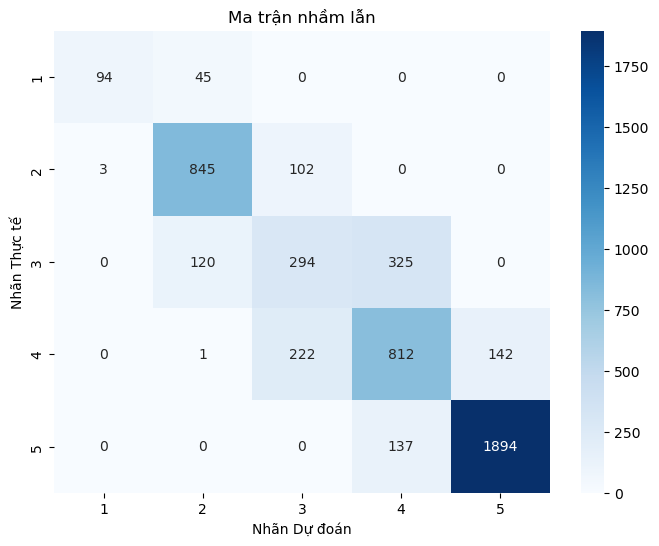

In [ ]:
# Tạo một mô hình SVM
# mô hình SVM được tạo với C=1.0, là giá trị mặc định thường được sử dụng 
# và random_state=42 để đảm bảo tính tái sử dụng của quá trình huấn luyện.
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Huấn luyện mô hình
svm_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = svm_model.predict(X_test)

# Đánh giá mô hình
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred))

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("Ma trận nhầm lẫn")
plt.xlabel("Nhãn Dự đoán")
plt.ylabel("Nhãn Thực tế")
plt.show()

#### Phân tích Kết Quả:

- Chất lượng Tốt (Lớp 1):
    - Precision cao (0.97) nhưng Recall thấp (0.68) có thể chỉ ra mô hình ít khi dự đoán sai chất lượng không khí tốt, nhưng nó bỏ lỡ nhiều trường hợp thực tế.
- Chất Lượng Trung Bình (Lớp 2):
    - Precision và Recall đều tốt (0.84 và 0.89), cho thấy mô hình có hiệu suất tốt trên lớp này.
- Chất Lượng Kém Đến Rất Kém (Lớp 3):
    - Precision thấp (0.48) và Recall cũng thấp (0.40), cho thấy khả năng dự đoán đúng trên lớp này không cao.
- Chất Lượng Rất Kém Đến Tệ (Lớp 4):
    - Precision và Recall khá tốt (0.64 và 0.69), nhưng có thể được cải thiện.
- Chất Lượng Rất Tệ (Lớp 5):
    - Precision và Recall rất cao (0.93), chỉ ra mô hình tốt trong việc dự đoán chất lượng không khí rất tệ.
    
**=> Mô hình có độ chính xác tổng thể là 78%**

#### Để cải thiện mô hình và tinh chỉnh siêu tham số C, ta có thể sử dụng GridSearchCV từ thư viện scikit-learn.

In [ ]:
# Tạo một mô hình SVM
svm_model = SVC(kernel='linear', random_state=42)

# Định nghĩa các giá trị C để thử nghiệm
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Tạo một GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')

# Huấn luyện GridSearchCV trên dữ liệu
grid_search.fit(X_train, y_train)

# In ra giá trị C tốt nhất được chọn
print("Best C:", grid_search.best_params_['C'])

# In ra độ chính xác tốt nhất trên tập kiểm tra
print("Best Accuracy:", grid_search.best_score_)

Best C: 100
Best Accuracy: 0.7935948361469711


**Dự đoán:**
- Tiến hành dự đoán từ 1 sample data với `best_model` vừa tạo ra như trên

In [ ]:
# Sử dụng mô hình đã tinh chỉnh từ GridSearchCV
best_svm_model = grid_search.best_estimator_

# Chuẩn hóa mẫu dữ liệu mới (nếu cần)
new_data = scaler.transform([[0.44, 700.95, 32.90, 35.99, 17.35, 20.33, 26.64, 8.99]])

# Dự đoán AQI cho mẫu dữ liệu mới
predicted_aqi = best_svm_model.predict(new_data)

print("Predicted AQI:", predicted_aqi[0])

Predicted AQI: 2


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 3. Mô hình KNN (K-Nearest Neighbors)

Mô hình K-Nearest Neighbors (KNN) hoạt động dựa trên nguyên lý đơn giản: "Nhóm các điểm dữ liệu gần nhau trong không gian đặc trưng sẽ có cùng nhãn hoặc giá trị dự đoán". KNN không học được một mô hình tường minh mà chỉ lưu trữ dữ liệu huấn luyện.

Cách hoạt động:
- Bước huấn luyện:
  - KNN lưu trữ toàn bộ dữ liệu huấn luyện.
- Bước dự đoán:
  - Khi có dữ liệu mới cần dự đoán, KNN tìm k điểm dữ liệu gần nhất với điểm dữ liệu mới trong không gian đặc trưng. K là số lân cận được xác định trước (hyperparameter).

  - KNN sử dụng một phép đo khoảng cách để xác định các điểm gần nhất.
  - Các điểm gần nhất này sẽ đóng vai trò trong việc quyết định nhãn hoặc giá trị dự đoán cho điểm dữ liệu mới. Điều này được thực hiện bằng cách đếm số lượng điểm thuộc mỗi nhóm trong k điểm gần nhất và chọn nhóm chiếm đa số là nhãn hoặc giá trị dự đoán cho điểm dữ liệu mới.

- Trong bài này, mô hình KNN nhóm em sẽ sử dụng phép đo khoảng cách Euclidean để xác định điểm gần nhất.
    - Euclidean là phép đo phổ biến và được sử dụng rộng rãi trong thuật toán KNN.
    - Công thức khoảng cách Euclidean giữa hai điểm $ p $ và $ q $ trong không gian nhiều chiều ($ n $ chiều) được tính bằng căn bậc hai của tổng bình phương của sự khác biệt giữa các thành phần tương ứng của hai điểm.
                    $$ \text{Euclidean distance} = \sqrt{\sum_{i=1}^{n} (q_i - p_i)^2} $$


    - Trong công thức này:
        - $ p $ và $ q $ là hai điểm trong không gian $ n $ chiều.
        - $ p_i $ và $ q_i $ là các thành phần tương ứng của hai điểm $ p $ và $ q $.
        - $ n $ là số chiều của không gian đặc trưng.


**Tiến hành huấn luyện**
- Đầu tiên, nhóm sẽ tiếp cận mô hình KNN với K = 5.
- Sau đó đánh giá mô hình này dựa trên *Cross-validation* bằng cách chia tập train thành 5 phần bằng nhau và sử dụng 4 phần để huấn luyện và phần còn lại để đánh giá mô hình, quá trình này được lặp lại 5 lần, mỗi lần sử dụng một fold khác nhau làm tập kiểm tra. Điều này nhằm thử nghiệm tính hiệu quả của mô hình KNN này với bộ dữ liệu mà chúng em có.  
 

In [18]:
# Tạo mô hình KNN Classifier (ví dụ với k=5)
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Huấn luyện mô hình với dữ liệu huấn luyện
knn_classifier.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred_classifier = knn_classifier.predict(X_test)

# Đánh giá hiệu suất của mô hình trên tập test
# accuracy = knn_classifier.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred_classifier)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7768069896743447


In [21]:
# Đánh giá mô hình bằng cross-validation trên tập train
cv_scores = cross_val_score(knn_classifier, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.76812314 0.78252234 0.77259186 0.775571   0.76564052]
Mean CV Accuracy: 0.7728897715988083


**Đánh giá**
- Kết quả của mô hình sau khi chia *4 fold* và sử dụng *Cross-Validation* cho ra kết quả khá tương đồng. Trung bình ở *77,29%*, mức này là khá tốt của 1 mô hình

**Cải thiện mô hình**
- K có thể ảnh hưởng đến hiện tượng overfitting hoặc underfitting. K càng lớn thì mô hình càng đơn giản nhưng có thể dẫn đến việc bỏ qua các chi tiết nhỏ, trong khi K càng nhỏ thì mô hình có thể trở nên quá phức tạp và dễ bị nhiễu.
- Nhóm sẽ sử dụng *K-Fold Cross-validation* để chia dữ liệu thành các tập con và đánh giá hiệu suất của mô hình với mỗi giá trị K. Điều này giúp chọn được giá trị K phù hợp cho mô hình KNN của nhóm, dựa trên mục tiêu tối ưu hóa hiệu suất và tránh hiện tượng *overfitting/underfitting*. (Có thể sử dụng *GridSearchCV* hoặc *RandomizedSearchCV*)
- Nhóm sẽ thử nghiệm với K=[1:101] để tìm ra K tốt nhất cho tập dữ liệu của nhóm.

**GridSearchCV**

In [47]:
# Tạo mô hình KNN
knn = KNeighborsClassifier()
n_neighbors = [num for num in range(3, 101) if num % 2 != 0]
# Thiết lập các tham số cần tìm kiếm
param_grid = {'n_neighbors': n_neighbors}  # Các giá trị K cần thử

# Sử dụng GridSearchCV để tìm giá trị K tốt nhất
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# In ra giá trị K tốt nhất và độ chính xác tương ứng
print("Giá trị K tốt nhất:", grid_search.best_params_)
print("Độ chính xác tốt nhất:", grid_search.best_score_)

Giá trị K tốt nhất: {'n_neighbors': 15}
Độ chính xác tốt nhất: 0.7817279046673287


**K-Fold Cross-Validation**

In [46]:
n_neighbors = [num for num in range(3, 101) if num % 2 != 0]

# Lặp qua từng giá trị K và thực hiện cross-validation
for k in n_neighbors:
    # Tạo mô hình KNN với giá trị K hiện tại
    knn = KNeighborsClassifier(n_neighbors=k)

    # Huấn luyện mô hình với dữ liệu huấn luyện
    knn.fit(X_train, y_train)
    
    # Thực hiện k-fold cross-validation với K hiện tại
    scores = cross_val_score(knn, X_train, y_train, cv=5)  # Sử dụng 5-fold cross-validation
    
    # Accuracy trung bình
    print(f"Độ chính xác với K={k}: {np.mean(scores)}")

Độ chính xác với K=3: 0.7678252234359484
Độ chính xác với K=5: 0.7728897715988083
Độ chính xác với K=7: 0.7785998013902681
Độ chính xác với K=9: 0.7799404170804369
Độ chính xác với K=11: 0.7810327706057596
Độ chính xác với K=13: 0.7806355511420059
Độ chính xác với K=15: 0.7817279046673287
Độ chính xác với K=17: 0.7811817279046673
Độ chính xác với K=19: 0.7804865938430984
Độ chính xác với K=21: 0.7795928500496525
Độ chính xác với K=23: 0.7777060575968222
Độ chính xác với K=25: 0.7776564051638529
Độ chính xác với K=27: 0.7768123138033763
Độ chính xác với K=29: 0.7755213505461768
Độ chính xác với K=31: 0.7759682224428998
Độ chính xác với K=33: 0.7754716981132075
Độ chính xác với K=35: 0.7749751737835153
Độ chính xác với K=37: 0.7743793445878848
Độ chính xác với K=39: 0.773286991062562
Độ chính xác với K=41: 0.771648460774578
Độ chính xác với K=43: 0.7716981132075471
Độ chính xác với K=45: 0.7709533267130089
Độ chính xác với K=47: 0.7703078450844092
Độ chính xác với K=49: 0.769662363455809

- Như vậy, nhìn vào kết quả *GridSearch* và kết quả từ *K-Fold Cross-Validation* ta thấy K tốt nhất = 15, nếu K lớn hơn hoặc nhỏ hơn độ chính đều giảm. Vì vậy không cần kiểm tra với K > 101.
- Lưu lại K=15, đây là model KNN tốt nhất cho tập dữ liệu của nhóm.

In [48]:
# Đánh giá hiệu suất của mô hình tốt nhất trên tập kiểm tra
best_model_knn = grid_search.best_estimator_
y_pred = best_model_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.778196981731533


**Dự đoán**


- Tiến hành dự đoán 1 mẫu với **best_model_knn** trên.

In [57]:
# Tạo sample data mới
new_data = {
    'no': 0.5,
    'co': 700.3,
    'so2': 35.1,
    'no2': 37.3,
    'o3': 52.7,
    'pm2_5': 19.5,
    'pm10': 20.2,
    'nh3': 7.99
}

# Chuyển sample data thành Dataframe
new_df = pd.DataFrame([new_data])

# Chuẩn hóa sample data
new_sample = scaler.transform(new_df)

# Dữ đoán aqi sử dụng best_model vừa huấn luyện trên 
predicted_aqi = best_model_knn.predict(new_sample)

print(f'Predicted AQI: {predicted_aqi}')

Predicted AQI: [2]
